In [38]:
import torch

from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from torchvision.models import resnet50, ResNet50_Weights
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder('./Training Data', transform=train_transforms)
val_dataset   = datasets.ImageFolder('./Validation Data', transform=val_test_transforms)
test_dataset  = datasets.ImageFolder('./Testing Data', transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features

model.fc = torch.nn.Linear(num_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete! 🎉")

Epoch [1/10], Loss: 0.7940
Epoch [2/10], Loss: 0.5065
Epoch [3/10], Loss: 0.3711
Epoch [4/10], Loss: 0.3084
Epoch [5/10], Loss: 0.2409
Epoch [6/10], Loss: 0.1948
Epoch [7/10], Loss: 0.1604
Epoch [8/10], Loss: 0.0524
Epoch [9/10], Loss: 0.0169
Epoch [10/10], Loss: 0.0093
Training complete! 🎉


In [29]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [33]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}\n")

print(classification_report(all_labels, all_preds, target_names=class_names))

Accuracy: 0.9040

              precision    recall  f1-score   support

       Aster       0.92      0.87      0.89       500
       Daisy       0.87      0.97      0.91       500
        Iris       0.93      0.89      0.91       500
    Lavender       0.89      0.93      0.91       500
        Lily       0.85      0.86      0.86       500
    Marigold       0.89      0.95      0.92       500
      Orchid       0.88      0.83      0.85       500
       Poppy       0.94      0.83      0.88       500
        Rose       0.91      0.96      0.93       500
   Sunflower       0.97      0.96      0.97       500

    accuracy                           0.90      5000
   macro avg       0.91      0.90      0.90      5000
weighted avg       0.91      0.90      0.90      5000



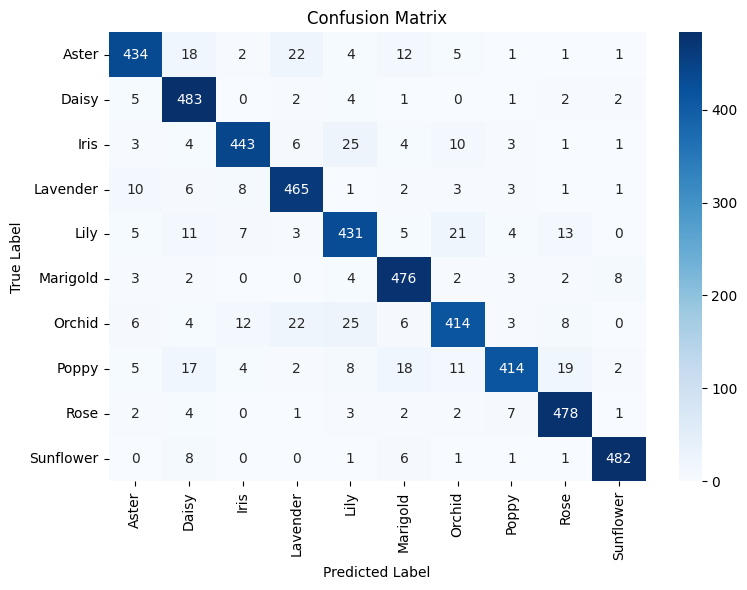

In [39]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [23]:
torch.save(model, 'resnet50_flowers_dataset.h5')